### Models X2 | created 01/07/2022 | generalisation of Models X
> This notebook was created with the goal of the computational analysis of the spot properties output of the Opera.

##### Imports

In [6]:
# General
import os
import sys
import pickle
import random
import string
import numpy as np
import pandas as pd
from datetime import date
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

# Random Forest
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)] 
numpy 1.22.4 
pandas 1.4.2 
plotnine 0.8.0 
statsmodels 0.13.2 
sklearn 1.1.1


#### 1) Pre-Processing
This is the selection of the right columns from the Opera output file.

In [7]:
def opera_to_df(input, n_skip = 9):
    # Import Tab separated opera file
    raw_df = pd.read_csv(input, sep = '\t', skiprows = n_skip)       # Read file (txt or csv) and skip header
    raw_df = raw_df.dropna(axis = 1, how = 'all')                    # Remove non-value columns
    return raw_df 

def filter_frame(df, col_idx):
    df_out = df[df['Column'] == col_idx]    # Select Column
    return df_out

##### 2) Model Fitting

In [8]:
def attach_trc(df, path_annotations):
    ls_trc = []

    # Obtain annotations
    with open(path_annotations) as f:
        for line in f:
            ls_trc.append(int(line))

    # Attach annotations
    df['trc'] = ls_trc

def get_rfc_model(df, features, prediction, estimators, depth_max):
    y = df[prediction]
    X = df[features]

    c = RandomForestClassifier(n_estimators = estimators, max_depth = depth_max)
    m_rfc = c.fit(X,y)

    p = m_rfc.predict(X)

    print(classification_report(y,p))
    ConfusionMatrixDisplay.from_predictions(y, p)

    return m_rfc

def store_rfc_model(model, path, name):
    # Identifier
    date_raw = date.today()
    d1 = date_raw.strftime("%d%m%y")

    identifier = d1 + "_" + name
    folderpath = os.path.join(path, identifier).replace("\\","/")
    os.mkdir(folderpath)

    descriptor =    str(model.feature_names_in_) + \
                    str(model.feature_importances_) + "\n" + \
                    "Features: " + str(model.n_features_) + "\n" + \
                    "Max Depth: " + str(model.max_depth)

    # Write Descriptor
    with open(folderpath + '/readme.txt', 'w') as f:
        f.write(descriptor)

    # Write Model
    pickle.dump(model, open(folderpath + f'/{identifier}.rfc', "wb"))


In [9]:
def getModel(input, rc, in_out):
    # 1) Obtain proper cuts
    df_clc = opera_to_df(in_out[0] + '/' + input)
    
    if len(rc) > 1:
        clc_pos = df_clc[df_clc['Row'] == rc[0]]
        clc_pos = df_clc[df_clc['Column'] == rc[1]]
    else:
        clc_pos = df_clc[df_clc['Column'] == rc[0]]

    # 2) Obtain Annotation Data
    attach_trc(clc_pos, in_out[0] + '/cep.txt')
    clc_pos = clc_pos[clc_pos.trc != 3]

    prediction = ['trc']
    features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

    m_rfc = get_rfc_model(clc_pos, features, prediction, estimators = 10, depth_max = 5)
    return m_rfc


C:\Users\Student\AppData\Local\Temp\ipykernel_19036\3768249418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_19036\3768249418.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.93      0.96      0.95       162
           1       0.89      0.83      0.86        65

    accuracy                           0.92       227
   macro avg       0.91      0.89      0.90       227
weighted avg       0.92      0.92      0.92       227



c:\Users\Student\Desktop\LocalEnvs\localenv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.


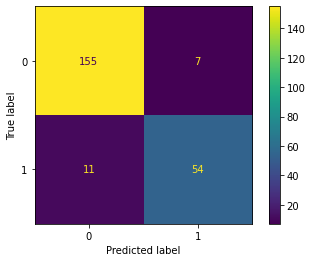

In [106]:
# MODEL GEN
in_out = ['data/0206_assay_novel/input_data', 'data/0206_assay_novel/output_data']
path = 'Objects_Population - coloc AR.txt'
model = getModel(path, [8], in_out)

store_rfc_model(model, in_out[1], 'prime')

In [5]:
features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

### Predictions | 1606 WT 1 | by 0206 prime
##### 1606 with 0206 prime

In [12]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_1 = ar_coloc_1606[ar_coloc_1606['Column'] == 4]
print(f'Initial: {len(ar_wt_pos_1606_1)}')

X = ar_wt_pos_1606_1[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_1['trc'] = trc_wt

ar_wt_pos_1606_1_view = ar_wt_pos_1606_1[ar_wt_pos_1606_1['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_1_view)}')
ar_wt_pos_1606_1_view.to_csv('data/1606_assay_novel/output_data/ar_wt_4_view.csv')

Initial: 850
Final: 313


C:\Users\Student\AppData\Local\Temp\ipykernel_5076\3526549738.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
ls_run_1 = []

with open('data/1606_assay_3X/output_data/06_on_3X2Hard.txt', 'r') as f:
    for line in f:
        ls_run_1.append(int(line))

In [53]:
full_size = len(ls_run_1)
full_fold = ls_run_1.count(1) + ls_run_1.count(0)
positive_fold = ls_run_1.count(1)

print(f'Fold Positive Percentage: {positive_fold/full_fold * 100} %')
print(full_fold)

Fold Positive Percentage: 74.0 %
50


### Clustering

In [38]:
ar_wt_8_view = pd.read_csv('data/1606_assay_novel/output_data/ar_wt_4_view.csv')

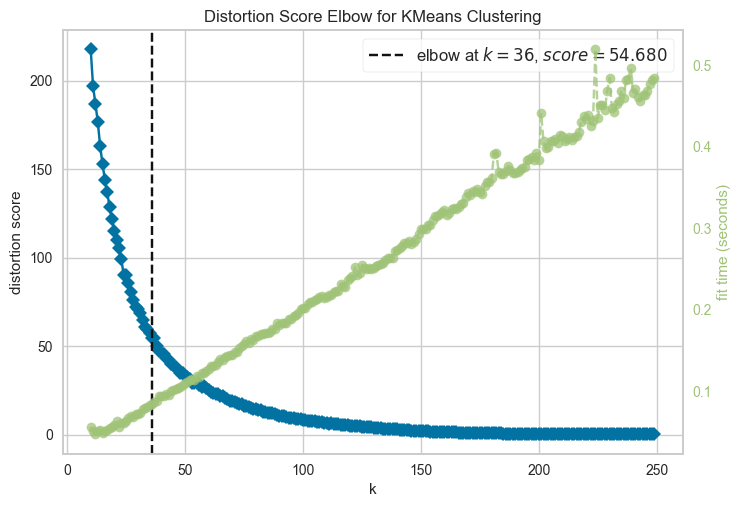

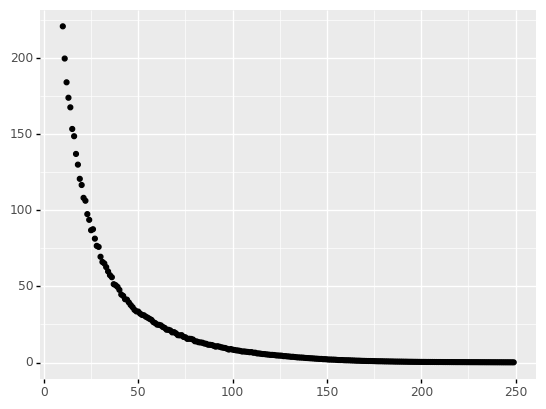

<ggplot: (178251193630)>

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer

X = ar_wt_8_view[['X', 'Y', 'Plane', 'Timepoint']]
X_scaled = StandardScaler().fit(X).transform(X)

K = range(10, 250)
withinSS = []

# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(10, 250))

# visualizer.fit(X_scaled)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

for k in K:
    m = KMeans(n_clusters = k).fit(X_scaled)
    withinSS.append(m.inertia_)

ggplot(aes(K, withinSS)) +\
    geom_point()

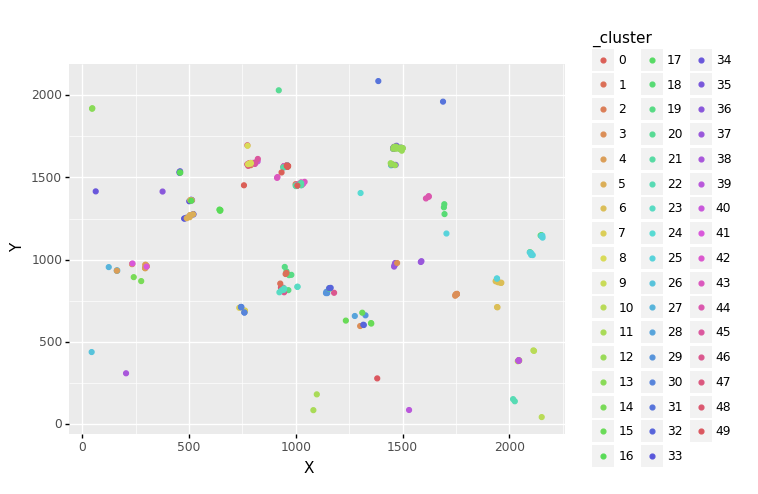

<ggplot: (178250255658)>

In [23]:
m = KMeans(n_clusters = 50).fit(X_scaled)
ar_wt_8_view['_cluster'] = pd.Categorical(m.labels_)

ggplot(ar_wt_8_view, aes('X', 'Y', color = '_cluster')) +\
    geom_point()

In [39]:
n_rows = ar_wt_8_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_8_view['cluster_id'] = empty_couples


In [28]:
ar_wt_8_view


,Unnamed: 0,Row,Column,Plane,Timepoint,Field,Object No,X,Y,Bounding Box,...,coloc AR - Uncorrected Spot Peak Intensity,coloc AR - Spot Contrast,coloc AR - Spot Background Intensity,coloc AR - Spot Area [px²],coloc AR - Region Intensity,coloc AR - Spot To Region Intensity,coloc AR - Object No in Nuclei Selected,coloc AR - Object No in Spots AR,trc,cluster_id
0,1,3,4,1,27,1,1,44,439,"[41,436,50,443]",...,749,0.067316,654.520000,58,544.098804,1.250882,4,4,1,0
1,7,3,4,2,38,1,1,2151,44,"[2146,40,2155,49]",...,733,0.069158,638.172414,79,629.833500,1.054187,8,6,1,0
2,39,3,4,3,61,2,2,1381,279,"[1377,276,1386,287]",...,1083,0.122693,846.290000,80,741.662000,1.219290,1,3,1,0
3,45,3,4,8,32,2,1,1705,1159,"[1699,1152,1709,1162]",...,1193,0.059017,1060.033333,64,845.394855,1.289006,4,3,1,0
4,46,3,4,9,36,2,1,1386,2085,"[1381,2080,1395,2093]",...,3336,0.330475,1678.750000,150,638.387495,3.408505,9,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,836,3,4,8,59,11,1,276,870,"[269,864,281,880]",...,908,0.206961,596.605263,124,437.317073,1.521171,3,2,1,0
309,840,3,4,9,26,11,3,235,977,"[228,973,240,980]",...,611,0.102533,497.357000,70,389.315000,1.339020,2,9,1,0
310,842,3,4,9,31,11,1,47,1920,"[39,1914,51,1930]",...,2023,0.095015,1671.925000,133,1368.671555,1.261879,4,3,1,0
311,843,3,4,9,32,11,1,46,1917,"[39,1912,51,1930]",...,2194,0.127473,1697.888889,173,1421.240730,1.280559,2,5,1,0


In [10]:
def dist(p1, p2):
    sp1, sp2 = np.array(p1[0:3]), np.array(p2[0:3])
    #print(f'SP1: {sp1}, SP2: {sp2}')
    sp_dist = np.linalg.norm(sp1 - sp2)
    
    tp1, tp2 = np.array(p1[3]), np.array(p2[3])
    tp_dist = np.linalg.norm(tp1 - tp2)

    fp1, fp2 = np.array(p1[4]), np.array(p2[4])
    fp_dist = np.linalg.norm(fp1 - fp2)

    return sp_dist, tp_dist, fp_dist

def buncher(df):
    at_id = 1   # Denotes the next available cluster id
    
    # 1) Go Across All Points
    for index, row in ar_wt_8_view.iterrows():
        ids_in_range = []   # Store all in same cluster
        current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])

        # 2) Fetch all close to point
        for in_index, in_row in ar_wt_8_view.iterrows():
            if in_index != index:
                against = (in_row['X'], in_row['Y'], in_row['Plane'], in_row['Timepoint'])
                sp_dist, tp_dist = dist(current, against)

                if sp_dist < 5 and tp_dist < 2:
                    ids_in_range.append(in_index)

        curr_id = at_id

        # If already has cluster, use that cluster
        if ar_wt_8_view.at[index, 'cluster_id'] != 0:
            curr_id = ar_wt_8_view.at[index, 'cluster_id']

        # 3) Cluster current and all found
        ar_wt_8_view.at[index, 'cluster_id'] = curr_id
        for idx in ids_in_range:
            ar_wt_8_view.at[idx, 'cluster_id'] = curr_id
        
        at_id += 1      # Advance available cluster id
    
    # 4) Add Cluster Sizes
    ar_wt_8_view['cluster_size'] = ar_wt_8_view.groupby('cluster_id')['cluster_id'].transform('count')

    ls_bunch = []
    for x in range(20):
        bunch = (ar_wt_8_view.cluster_size >= x).sum()
        ls_bunch.append(bunch)
    return ls_bunch

def buncher_glx(df):
    at_id = 1   # Denotes the next available cluster id
    
    # 1) Go Across All Points
    for index, row in df.iterrows():
        ids_in_range = []   # Store all in same cluster
        current = (row['Position X [µm]'], row['Position Y [µm]'], row['Plane'], row['Timepoint'], row['Field'])

        # 2) Fetch all close to point
        for in_index, in_row in df.iterrows():
            if in_index != index:
                against = (in_row['Position X [µm]'], in_row['Position Y [µm]'], in_row['Plane'], in_row['Timepoint'], row['Field'])
                sp_dist, tp_dist, fp_dist = dist(current, against)

                if sp_dist < 2 and tp_dist < 2 and fp_dist == 0:
                    ids_in_range.append(in_index)

        # 3) Obtain ids_in_range subset that has clusters
        ls_idxs_to_remove = []
        ls_clusters_to_connect = []

        for idx in ids_in_range:
            if df.at[idx, 'cluster_id'] != 0:
                ls_idxs_to_remove.append(idx)
                ls_clusters_to_connect.append(df.at[idx, 'cluster_id'])

        ids_in_range = [x for x in ids_in_range if x not in ls_idxs_to_remove]

        curr_id = at_id

        # 3.1) Replace In Existent Clusters
        df['cluster_id'] = df['cluster_id'].replace(ls_clusters_to_connect, curr_id)

        # 3.2) Add to novel
        for idx in ids_in_range:
            df.at[idx, 'cluster_id'] = curr_id

        at_id += 1      # Advance available cluster id
    
    # 4) Add Cluster Sizes
    df['cluster_size'] = df.groupby('cluster_id')['cluster_id'].transform('count')

    ls_bunch = []
    for x in range(20):
        bunch = (df.cluster_size >= x).sum()
        ls_bunch.append(bunch)
    return ls_bunch


    # total, bunches = len(ar_wt_8_view), (ar_wt_8_view.cluster_size >= 3).sum()
    # print(total, bunches)


In [11]:
def nuc_buncher(df):
    timepoints = df.Timepoint.unique()  # Obtain unique timepoints

    glob_nuc_counter = 1

    for timepoint in timepoints:
        reference = []  # List of connections

        df_tp = df[df.Timepoint == timepoint]   # Subdf with only timepoint
        clusters = df_tp.cluster_id.unique()

        for cluster in clusters:
            # FIRST check whether we are dealing with cluster 0
            # this is the 'empty' cluster for spots that could not
            # be clustered and should therefore be ignored.
            if cluster != 0:    
                nps_current = []
                
                df_cluster = df_tp[df_tp.cluster_id == cluster]

                for index, row in df_cluster.iterrows():
                    # Obtain current NP
                    np_row = (row['Plane'], row['coloc AR - Object No in Clustered Nuclei w/o Border Round Selected'], 0)
                    if np_row not in nps_current:
                        nps_current.append(np_row)
                
                terminate = False

                for np_row in nps_current:
                    # Find nucleus
                    for idx, ref in enumerate(reference):
                        # If FOUND
                        if ref[0:2] == np_row[0:2]:
                            true_nuc_id = ref[2]
                            nps_annotated = [(x[0], x[1], true_nuc_id) for x in nps_current]
                            for np_annotated in nps_annotated:
                                if np_annotated not in reference:
                                    reference.append(np_annotated)
                            df.nucleus_true.mask(df.cluster_id == cluster, true_nuc_id, inplace = True)
                            terminate = True
                    if terminate is True:
                        break

                if terminate is False:
                    # If NOT FOUND
                    nps_annotated = [(x[0], x[1], glob_nuc_counter) for x in nps_current]
                    # Put in references
                    for np_annotated in nps_annotated:
                        reference.append(np_annotated)
                    # Mask out
                    df.nucleus_true.mask(df.cluster_id == cluster, glob_nuc_counter, inplace = True)
                    glob_nuc_counter += 1

In [96]:
a = [(2,2), (7,2), (8,2)]
b = [(4,5), (12, 2), (8,2)]

In [12]:
ar_wt_8_view = pd.read_csv('data/1606_assay_novel/output_data/ar_wt_4_view.csv')

n_rows = ar_wt_8_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_8_view['cluster_id'] = empty_couples
ar_wt_8_view['cluster_size'] = empty_couples
ar_wt_8_view['nucleus_true'] = empty_couples

ls_bunch = buncher_glx(ar_wt_8_view)
nuc_buncher(ar_wt_8_view)

ggplot(aes(range(0, len(ls_bunch)), ls_bunch)) +\
    geom_point()

ar_wt_8_view.to_csv('data/1606_assay_novel/output_data/ar_wt_4_view_annotated.csv')


KeyError: 'coloc AR - Object No in Clustered Nuclei w/o Border Round Selected'

In [127]:
unique_nuclei = ar_wt_8_view.nucleus_true.unique()

for nucleus in unique_nuclei:
    cut = ar_wt_8_view[ar_wt_8_view.nucleus_true == nucleus]
    unique_clusters = cut.cluster_id.unique()
    if len(unique_clusters) > 1:
        print(f'NUC: {nucleus}')

NUC: 78
NUC: 96
NUC: 58
NUC: 111


In [115]:
print(ls_bunch[4])

282


In [159]:
# GREEDY
at_id = 1

ctr = 0
snapshot = []

# Go across each row
for index, row in ar_wt_8_view.iterrows():
    if ctr > 10:
        break
    ctr += 1
    current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])
    # Check against each other row
    for a_index, a_row in ar_wt_8_view.iterrows():
        if a_index != index:
            against = (a_row['X'], a_row['Y'], a_row['Plane'], a_row['Timepoint'])
            # Get SPATIAL (SP) and TEMPORAL (TP) distance
            sp_dist, tp_dist = dist(current, against)

            if sp_dist < 10 and tp_dist < 2:
                # Case 1 | There was no annotation
                if row['cluster_id'] == 0 and a_row['cluster_id'] == 0:
                    ar_wt_8_view.at[index, 'cluster_id'] = at_id
                    ar_wt_8_view.at[a_index, 'cluster_id'] = at_id
                    at_id += 1
                    snapshot.append(ar_wt_8_view.copy())
                    print('de novo')
                # Case 2 | Current is not annotated
                elif row['cluster_id'] == 0 and a_row['cluster_id'] != 0:
                    ar_wt_8_view.at[index, 'cluster_id'] = ar_wt_8_view.at[a_index, 'cluster_id'] 
                    print('propell')
                # Case 3 | Both are annotated
                elif row['cluster_id'] != 0 and a_row['cluster_id'] != 0:
                    a_value = a_row['cluster_id']
                    ar_wt_8_view['cluster_id'].replace({a_value, 1})
                    print('reflex')

print(at_id)

reflex
reflex
reflex
1


In [71]:
# GREEDY EXPANSION
# FLAT: 3.7s
# FLAT + COMPARISONS: 6.4s
at_id = 1

for index, row in ar_wt_8_view.iterrows():
    ids_in_range = []   # Store all in same cluster
    current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])

    for in_index, in_row in ar_wt_8_view.iterrows():
        if in_index != index:
            against = (in_row['X'], in_row['Y'], in_row['Plane'], in_row['Timepoint'])
            sp_dist, tp_dist = dist(current, against)

            if sp_dist < 10 and tp_dist < 2:
                ids_in_range.append(in_index)

    curr_id = at_id

    # Use Already present IF it is
    if ar_wt_8_view.at[index, 'cluster_id'] != 0:
        curr_id = ar_wt_8_view.at[index, 'cluster_id']

    ar_wt_8_view.at[index, 'cluster_id'] = curr_id
    for idx in ids_in_range:
        ar_wt_8_view.at[idx, 'cluster_id'] = curr_id
    
    at_id += 1
ar_wt_8_view['cluster_size'] = ar_wt_8_view.groupby('cluster_id')['cluster_id'].transform('count')

In [162]:
ar_coloc = ar_wt_8_view[ar_wt_8_view.cluster_id != 0]
print(len(ar_coloc['cluster_id']))
len(set(ar_coloc['cluster_id']))

np.bincount(np.array(ar_coloc['cluster_id']))

259


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  1,  1,  1,  0,
        0,  0,  1,  1,  1,  3,  0,  1,  1,  1,  1,  0,  0,  0,  1,  0,  0,
        3,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  5,
        0,  4,  0,  0,  0,  0,  0,  0,  0,  4,  0,  3,  6,  0,  3,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  1,  0,  0,  3,  0,  1,  3,
        0,  0,  8,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  1,  7,  0, 22, 11,
        0,  0,  0,  0,  0,  0, 16, 11,  0,  0,  1,  0,  1,  1,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

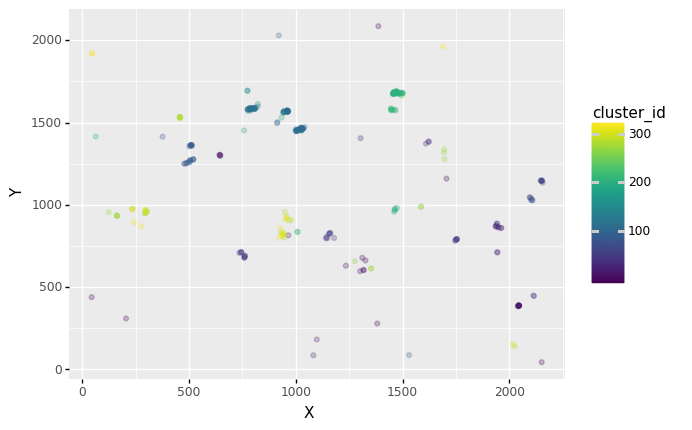

<ggplot: (143034212349)>

In [72]:
ggplot(ar_coloc, aes('X', 'Y', color = 'cluster_id')) +\
    geom_point(alpha = .25)

In [52]:
a = np.array((22, 44))
b = np.array((44, 56))
np.linalg.norm(a-b)

25.059928172283335

In [54]:
row = ar_wt_8_view.iloc[146]
current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])

a_row = ar_wt_8_view.iloc[169]
a_current = (a_row['X'], a_row['Y'], a_row['Plane'], a_row['Timepoint'])

sp, tp = dist(current, a_current)
print(sp, tp)

SP1: [ 942 1563    5], SP2: [ 782 1584    6]
161.37533888422976 1.0


In [33]:
corell1, corell2, corell3 = snapshot[0], snapshot[1], snapshot[2]

### Nuclei

In [76]:
nuclei_1606_wt = opera_to_df('data/1606_assay_novel/input_data/nuclei.txt', n_skip = 8)

In [77]:
nuclei_1606_wt = filter_frame(nuclei_1606_wt, 4)
nuclei_1606_wt = nuclei_1606_wt.sort_values(by = ['Timepoint'])
nuclei_1606_wt['Nuclei - Ratio'] = nuclei_1606_wt['Nuclei Selected - Number of Objects'] / nuclei_1606_wt['Nuclei - Number of Objects']

mean_ratio = nuclei_1606_wt['Nuclei - Ratio'].mean()
mean_selected = nuclei_1606_wt['Nuclei Selected - Number of Objects'].mean()
print(f'Mean Ratio: {mean_ratio * 100} %, Mean Selected = {mean_selected}')

Mean Ratio: 25.686065007250935 %, Mean Selected = 64.26666666666667


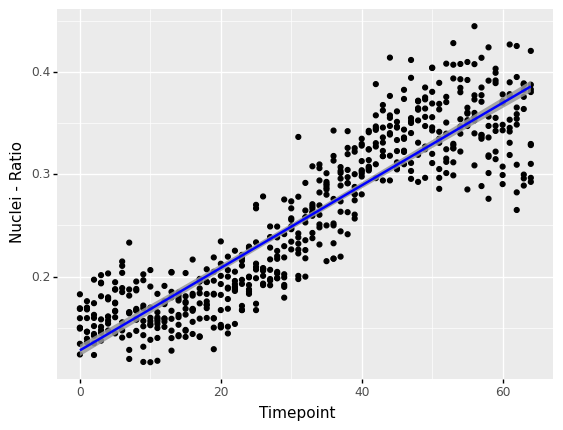

<ggplot: (132030482583)>

In [55]:
ggplot(nuclei_1606_wt, aes('Timepoint', 'Nuclei - Ratio')) +\
    geom_point() +\
    geom_smooth(method = "lm", color = 'b', alpha = 0.85)

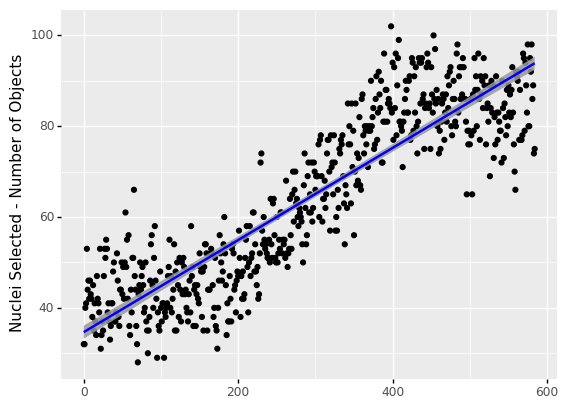

<ggplot: (132033095263)>

In [58]:
ggplot(nuclei_1606_wt, aes(range(0, len(nuclei_1606_wt)), 'Nuclei Selected - Number of Objects')) +\
    geom_point() +\
    geom_smooth(method = "lm", color = 'b', alpha = 0.85)

In [65]:
ar_1606_full = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_1606_wt_4 = ar_1606_full[ar_1606_full['Column'] == 4]
ar_1606_wt_4.to_csv('data/1606_assay_novel/output_data/ar_wt_4_full.csv')

### Predictions | 1606 WT 2 | by 0206 prime
#### Amount of True Coloc Events

In [21]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_6 = ar_coloc_1606[ar_coloc_1606['Column'] == 6]
print(f'Initial: {len(ar_wt_pos_1606_6)}')

X = ar_wt_pos_1606_6[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_6['trc'] = trc_wt

ar_wt_pos_1606_6_view = ar_wt_pos_1606_6[ar_wt_pos_1606_6['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_6_view)}')
ar_wt_pos_1606_6_view.to_csv('data/1606_assay_novel/output_data/ar_wt_6_view.csv')

Initial: 964
Final: 337


C:\Users\acher\AppData\Local\Temp\ipykernel_17548\3952481903.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
n_rows = ar_wt_pos_1606_6_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_pos_1606_6_view['cluster_id'] = empty_couples

C:\Users\acher\AppData\Local\Temp\ipykernel_17548\28920741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


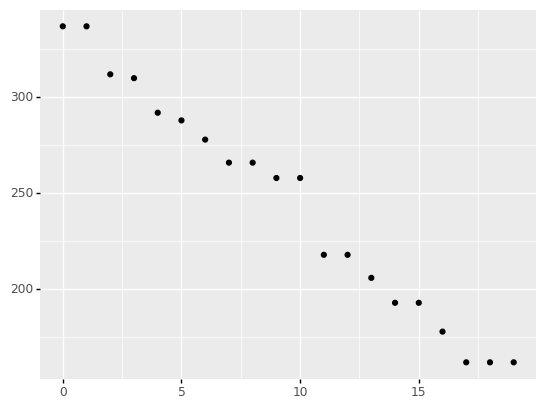

<ggplot: (116178736228)>

In [54]:
ar_wt_pos_1606_6_view = pd.read_csv('data/1606_assay_novel/output_data/ar_wt_6_view.csv')

n_rows = ar_wt_pos_1606_6_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_pos_1606_6_view['cluster_id'] = empty_couples
ar_wt_pos_1606_6_view['cluster_size'] = empty_couples

ls_bunch = buncher_glx(ar_wt_pos_1606_6_view)

ggplot(aes(range(0, len(ls_bunch)), ls_bunch)) +\
    geom_point()

In [55]:
print(ls_bunch[4])

292


#### Nuclei Analysis

In [41]:
nuclei_1606_wt_6 = opera_to_df('data/1606_assay_novel/input_data/nuclei.txt', n_skip = 8)

nuclei_1606_wt_6 = filter_frame(nuclei_1606_wt_6, 6)
nuclei_1606_wt_6 = nuclei_1606_wt_6.sort_values(by = ['Timepoint'])
nuclei_1606_wt_6['Nuclei - Ratio'] = nuclei_1606_wt_6['Nuclei Selected - Number of Objects'] / nuclei_1606_wt_6['Nuclei - Number of Objects']

mean_ratio = nuclei_1606_wt_6['Nuclei - Ratio'].mean()
mean_selected = nuclei_1606_wt_6['Nuclei Selected - Number of Objects'].mean()
print(f'Mean Ratio: {mean_ratio * 100} %, Mean Selected = {mean_selected}')

Mean Ratio: 28.390136322776748 %, Mean Selected = 78.13162393162393


### Predictions | 1606 C4 (WELL 8) | by 0206 prime

In [45]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_8 = ar_coloc_1606[ar_coloc_1606['Column'] == 8]
print(f'Initial: {len(ar_wt_pos_1606_8)}')

X = ar_wt_pos_1606_8[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_8['trc'] = trc_wt

ar_wt_pos_1606_8_view = ar_wt_pos_1606_8[ar_wt_pos_1606_8['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_8_view)}')
ar_wt_pos_1606_8_view.to_csv('data/1606_assay_novel/output_data/ar_wt_8_view.csv')

Initial: 570
Final: 66


C:\Users\Student\AppData\Local\Temp\ipykernel_19036\2458360915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
ls_run_1 = []

with open('data/1606_assay_novel/output_data/lin_lab_1606_8_by_0206_prime_fALL.txt', 'r') as f:
    for line in f:
        ls_run_1.append(int(line))

full_size = len(ls_run_1)
full_fold = ls_run_1.count(1) + ls_run_1.count(0)
positive_fold = ls_run_1.count(1)

print(f'Fold Positive Percentage: {positive_fold/full_fold * 100} %')
print(full_fold)


Fold Positive Percentage: 30.303030303030305 %
66


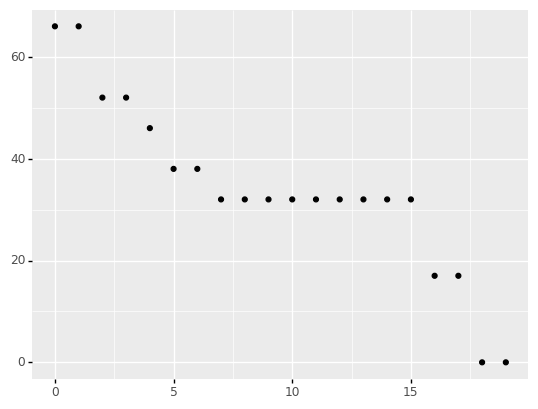

<ggplot: (116178765470)>

In [39]:
ar_wt_pos_1606_8_view = pd.read_csv('data/1606_assay_novel/output_data/ar_wt_8_view.csv')

n_rows = ar_wt_pos_1606_8_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_pos_1606_8_view['cluster_id'] = empty_couples
ar_wt_pos_1606_8_view['cluster_size'] = empty_couples

ls_bunch = buncher_glx(ar_wt_pos_1606_8_view)

ggplot(aes(range(0, len(ls_bunch)), ls_bunch)) +\
    geom_point()

In [40]:
print(ls_bunch[4])

46


In [43]:
nuclei_1606_c4_8 = opera_to_df('data/1606_assay_novel/input_data/nuclei.txt', n_skip = 8)

nuclei_1606_c4_8 = filter_frame(nuclei_1606_c4_8, 8)
nuclei_1606_c4_8 = nuclei_1606_c4_8.sort_values(by = ['Timepoint'])
nuclei_1606_c4_8['Nuclei - Ratio'] = nuclei_1606_c4_8['Nuclei Selected - Number of Objects'] / nuclei_1606_c4_8['Nuclei - Number of Objects']

mean_ratio = nuclei_1606_c4_8['Nuclei - Ratio'].mean()
mean_selected = nuclei_1606_c4_8['Nuclei Selected - Number of Objects'].mean()
print(f'Mean Ratio: {mean_ratio * 100} %, Mean Selected = {mean_selected}')

Mean Ratio: 22.665082061091294 %, Mean Selected = 41.758974358974356


### Predictions | 1606 C4 (WELL 9) | by 0206 prime

In [59]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_9 = ar_coloc_1606[ar_coloc_1606['Column'] == 9]
print(f'Initial: {len(ar_wt_pos_1606_9)}')

X = ar_wt_pos_1606_9[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_9['trc'] = trc_wt

ar_wt_pos_1606_9_view = ar_wt_pos_1606_9[ar_wt_pos_1606_9['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_9_view)}')
ar_wt_pos_1606_9_view.to_csv('data/1606_assay_novel/output_data/ar_wt_9_view.csv')

Initial: 680
Final: 95


C:\Users\Student\AppData\Local\Temp\ipykernel_19036\2225132384.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


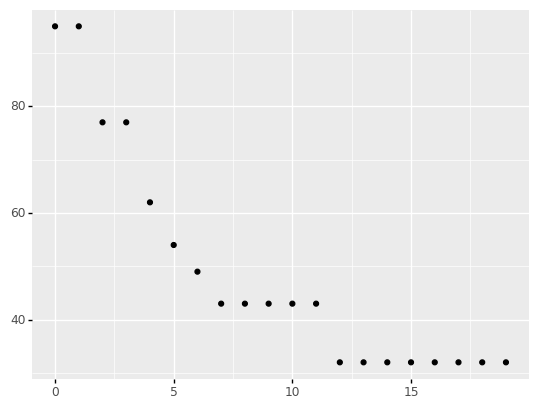

<ggplot: (116179978691)>

In [60]:
ar_wt_pos_1606_9_view = pd.read_csv('data/1606_assay_novel/output_data/ar_wt_9_view.csv')

n_rows = ar_wt_pos_1606_9_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_pos_1606_9_view['cluster_id'] = empty_couples
ar_wt_pos_1606_9_view['cluster_size'] = empty_couples

ls_bunch = buncher_glx(ar_wt_pos_1606_9_view)

ggplot(aes(range(0, len(ls_bunch)), ls_bunch)) +\
    geom_point()

In [61]:
print(ls_bunch[4])

62


In [62]:
nuclei_1606_c4_9 = opera_to_df('data/1606_assay_novel/input_data/nuclei.txt', n_skip = 8)

nuclei_1606_c4_9 = filter_frame(nuclei_1606_c4_9, 9)
nuclei_1606_c4_9 = nuclei_1606_c4_9.sort_values(by = ['Timepoint'])
nuclei_1606_c4_9['Nuclei - Ratio'] = nuclei_1606_c4_9['Nuclei Selected - Number of Objects'] / nuclei_1606_c4_9['Nuclei - Number of Objects']

mean_ratio = nuclei_1606_c4_9['Nuclei - Ratio'].mean()
mean_selected = nuclei_1606_c4_9['Nuclei Selected - Number of Objects'].mean()
print(f'Mean Ratio: {mean_ratio * 100} %, Mean Selected = {mean_selected}')

Mean Ratio: 21.632700854644604 %, Mean Selected = 45.42564102564103


### Predictions | 0206 C4+ (WELL 6) | by 0206 prime

In [94]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_0206 = opera_to_df('data/0206_assay_novel/input_data/Objects_Population - coloc AR.txt')
ar_pos_0206_6 = ar_coloc_0206[ar_coloc_0206['Column'] == 6]
print(f'Initial: {len(ar_pos_0206_6)}')

X = ar_pos_0206_6[features]

trc_wt = model.predict(X)
ar_pos_0206_6['trc'] = trc_wt

ar_pos_0206_6_view = ar_pos_0206_6[ar_pos_0206_6['trc'] == 1]
print(f'Final: {len(ar_pos_0206_6_view)}')
ar_pos_0206_6_view.to_csv('data/0206_assay_novel/output_data/ar_wt_6_view.csv')

Initial: 1499
Final: 92


C:\Users\Student\AppData\Local\Temp\ipykernel_19036\2705200697.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


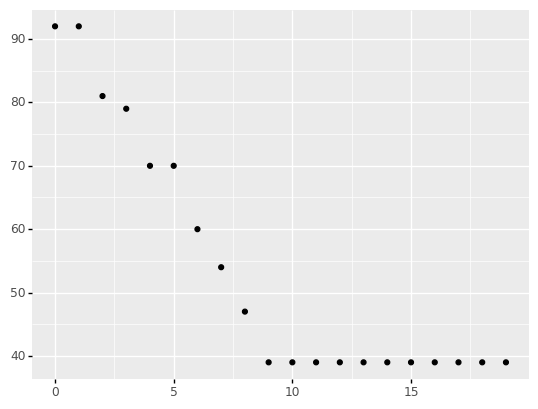

<ggplot: (116183169346)>

In [95]:
ar_wt_pos_0206_6_view = pd.read_csv('data/0206_assay_novel/output_data/ar_wt_6_view.csv')

n_rows = ar_wt_pos_0206_6_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_pos_0206_6_view['cluster_id'] = empty_couples
ar_wt_pos_0206_6_view['cluster_size'] = empty_couples

ls_bunch = buncher_glx(ar_wt_pos_0206_6_view)

ggplot(aes(range(0, len(ls_bunch)), ls_bunch)) +\
    geom_point()

In [96]:
print(ls_bunch[4])

70


In [101]:
nuclei_0206_6 = opera_to_df('data/0206_assay_novel/input_data/nuclei.txt', n_skip = 8)

nuclei_0206_6 = filter_frame(nuclei_0206_6, 6)
nuclei_0206_6 = nuclei_0206_6.sort_values(by = ['Timepoint'])
nuclei_0206_6['Nuclei - Ratio'] = nuclei_0206_6['Nuclei Selected - Number of Objects'] / nuclei_0206_6['Nuclei - Number of Objects']

mean_ratio = nuclei_0206_6['Nuclei - Ratio'].mean()
mean_selected = nuclei_0206_6['Nuclei Selected - Number of Objects'].mean()
print(f'Mean Ratio: {mean_ratio * 100} %, Mean Selected = {mean_selected}')

Mean Ratio: 17.687744801860703 %, Mean Selected = 87.01346153846154


### 1606 Well WT (1) ASSAY 3X

In [13]:
features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

In [14]:
ar_wt_1606_3X = opera_to_df('data/1606_assay_3X/input_data/Objects_Population - coloc AR.txt')
ar_wt_1606_4_3X = filter_frame(ar_wt_1606_3X, 4)
ar_wt_1606_4_3X.to_csv('data/1606_assay_3X/output_data/ar_wt_4_full.csv')

In [15]:
# LOAD model
model = pickle.load(open('data/1606_assay_3X/output_data/080722_3X_2/080722_3X_2.rfc', 'rb'))
print(f'Initial: {len(ar_wt_1606_4_3X)}')

X = ar_wt_1606_4_3X[features]

trc_wt = model.predict(X)
ar_wt_1606_4_3X['trc'] = trc_wt

ar_wt_1606_4_3X_view = ar_wt_1606_4_3X[ar_wt_1606_4_3X['trc'] == 1]
print(f'Final: {len(ar_wt_1606_4_3X_view)}')
ar_wt_1606_4_3X_view.to_csv('data/1606_assay_3X/output_data/ar_wt_4_view.csv')

Initial: 1350
Final: 339


C:\Users\acher\AppData\Local\Temp\ipykernel_5276\3573644245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        19

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



C:\Users\Student\AppData\Local\Temp\ipykernel_21480\1462771134.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_21480\1462771134.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
c:\Users\Student\Desktop\LocalEnvs\localenv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.


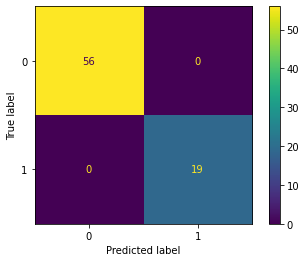

In [41]:
# MODEL GEN
in_out = ['data/1606_assay_3X/input_data', 'data/1606_assay_3X/output_data']
path = 'Objects_Population - coloc AR.txt'
model = getModel(path, [4], in_out)

store_rfc_model(model, in_out[1], '3X_2')

### 1606 Well 6

In [16]:
features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

In [17]:
ar_wt_1606_3X = opera_to_df('data/1606_assay_3X/input_data/Objects_Population - coloc AR.txt')
ar_wt_1606_6_3X = filter_frame(ar_wt_1606_3X, 6)
ar_wt_1606_6_3X.to_csv('data/1606_assay_3X/output_data/ar_wt_6_full.csv')

In [18]:
# LOAD model
model = pickle.load(open('data/1606_assay_3X/output_data/080722_3X_2/080722_3X_2.rfc', 'rb'))
print(f'Initial: {len(ar_wt_1606_6_3X)}')

X = ar_wt_1606_6_3X[features]

trc_wt = model.predict(X)
ar_wt_1606_6_3X['trc'] = trc_wt

ar_wt_1606_6_3X_view = ar_wt_1606_6_3X[ar_wt_1606_6_3X['trc'] == 1]
print(f'Final: {len(ar_wt_1606_6_3X_view)}')
ar_wt_1606_6_3X_view.to_csv('data/1606_assay_3X/output_data/ar_wt_6_view.csv')

Initial: 1870
Final: 484


C:\Users\acher\AppData\Local\Temp\ipykernel_5276\3763462866.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
ar_wt_6_view = pd.read_csv('data/1606_assay_3X/output_data/ar_wt_6_view.csv')

n_rows = ar_wt_6_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_6_view['cluster_id'] = empty_couples
ar_wt_6_view['cluster_size'] = empty_couples
ar_wt_6_view['nucleus_true'] = empty_couples

ls_bunch = buncher_glx(ar_wt_6_view)
nuc_buncher(ar_wt_6_view)



ar_wt_6_view.to_csv('data/1606_assay_3X/output_data/ar_wt_6_view_anno.csv')

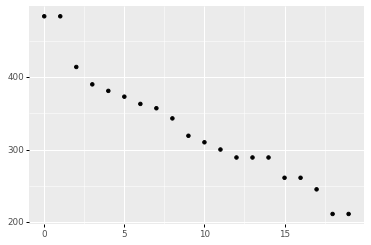

<ggplot: (117572652852)>

In [20]:
ggplot(aes(range(0, len(ls_bunch)), ls_bunch)) +\
    geom_point()

In [22]:
ar_wt_6_view = ar_wt_6_view[ar_wt_6_view.cluster_size > 5]
unique_nuclei = ar_wt_6_view.nucleus_true.unique()
print(f'UNIQUE NUCLEI: {len(unique_nuclei)}')

for nucleus in unique_nuclei:
    fcut = ar_wt_6_view[ar_wt_6_view.cluster_size > 5]
    cut = fcut[fcut.nucleus_true == nucleus]
    unique_clusters = cut.cluster_id.unique()
    if len(unique_clusters) > 1:
        print(f'NUC: {nucleus}')

UNIQUE NUCLEI: 16
NUC: 60
NUC: 120
NUC: 76


In [35]:
plate_results = opera_to_df('data/1606_assay_3X/input_data/plate_results.txt', n_skip=8)

well_6_results = plate_results[plate_results['Column'] == 6]

timepoints = well_6_results.Timepoint.unique()
nuc_total = []
nuc_selected = []

for timepoint in timepoints:
    tp_cut = well_6_results[well_6_results['Timepoint'] == timepoint]

    mean_nuc = tp_cut['Clustered Nuclei w/o Border Round - Number of Objects'].mean()
    mean_nuc_selected = tp_cut['Clustered Nuclei w/o Border Round Selected - Number of Objects'].mean()
    nuc_total.append(mean_nuc)
    nuc_selected.append(mean_nuc_selected)



In [48]:
df_coloc = ar_wt_6_view[ar_wt_6_view.nucleus_true != 0].groupby('Timepoint').apply(lambda x: len(x['nucleus_true'].unique())).rename('Nuclei w/ Coloc').to_frame()
df = pd.DataFrame(list(zip(timepoints, nuc_total, nuc_selected)), columns = ['Timepoint', 'Nuclei', 'Nuclei Selected'])

df = pd.merge(df_coloc, df, on = ['Timepoint'], how = 'left')
df['Nuclei - Ratio'] = df['Nuclei w/ Coloc'] / df['Nuclei Selected']

In [50]:
def fetch_well_results(df, path_plate_results):
    # Obtain plate results
    pr = opera_to_df(path_plate_results, n_skip=8)
    plate_cut = pr[(pr.Row == df.Row.unique()[0]) 
                    & (pr.Column == df.Column.unique()[0])]

    timepoints = plate_cut.Timepoint.unique()
    nuc_total, nuc_selected = [], []

    # 1) Obtain TOTAL and SELECTED from plate results
    for timepoint in timepoints:
        plate_tp_cut = plate_cut[plate_cut.Timepoint == timepoint]

        mean_nuc_total = plate_tp_cut['Clustered Nuclei w/o Border Round - Number of Objects'].mean()
        mean_nuc_selected = plate_tp_cut['Clustered Nuclei w/o Border Round Selected - Number of Objects'].mean()

        nuc_total.append(mean_nuc_total)
        nuc_selected.append(mean_nuc_selected)
    
    # 2) Obtain WITH COLOC from df cut
    n_nuc_with_coloc = df[df.nucleus_true != 0].groupby('Timepoint').apply(lambda x: len(x['nucleus_true'].unique())).rename('Nuclei w/ Coloc').to_frame()

    # 3) Compile into one dataframe
        # Compile plate results
    out_df = pd.DataFrame(list(zip(timepoints, nuc_total, nuc_selected)), columns = ['Timepoint', 'Nuclei', 'Nuclei Selected'])
        # Compile coloc results
    out_df = pd.merge(n_nuc_with_coloc, out_df, on = ['Timepoint'], how = 'left')
    out_df['Nuclei Ratio'] = out_df['Nuclei w/ Coloc'] / out_df['Nuclei Selected']
    return out_df

In [51]:
df = fetch_well_results(ar_wt_6_view, 'data/1606_assay_3X/input_data/plate_results.txt')

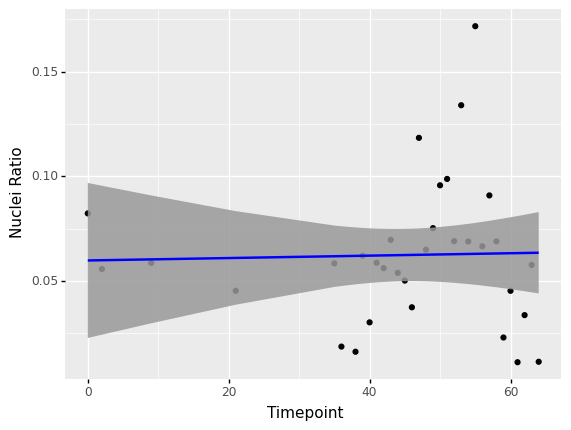

<ggplot: (117285121514)>

In [53]:
ggplot(df, aes('Timepoint', 'Nuclei Ratio')) +\
    geom_point() +\
    geom_smooth(method = "lm", color = 'b', alpha = 0.85)

### 1606 WELL 8

In [71]:
# LOAD model
model = pickle.load(open('data/1606_assay_3X/output_data/080722_3X_2/080722_3X_2.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay_3X/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_8 = ar_coloc_1606[ar_coloc_1606['Column'] == 8]
print(f'Initial: {len(ar_wt_pos_1606_8)}')

X = ar_wt_pos_1606_8[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_8['trc'] = trc_wt

ar_wt_pos_1606_8_view = ar_wt_pos_1606_8[ar_wt_pos_1606_8['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_8_view)}')
ar_wt_pos_1606_8_view.to_csv('data/1606_assay_3X/output_data/ar_wt_8_view.csv')

Initial: 1234
Final: 50


C:\Users\Student\AppData\Local\Temp\ipykernel_21480\1760665398.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 1606 WELL 9

In [72]:
# LOAD model
model = pickle.load(open('data/1606_assay_3X/output_data/080722_3X_2/080722_3X_2.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay_3X/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_9 = ar_coloc_1606[ar_coloc_1606['Column'] == 9]
print(f'Initial: {len(ar_wt_pos_1606_9)}')

X = ar_wt_pos_1606_9[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_9['trc'] = trc_wt

ar_wt_pos_1606_9_view = ar_wt_pos_1606_9[ar_wt_pos_1606_9['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_9_view)}')
ar_wt_pos_1606_9_view.to_csv('data/1606_assay_3X/output_data/ar_wt_9_view.csv')

Initial: 1031
Final: 134


C:\Users\Student\AppData\Local\Temp\ipykernel_21480\2945185581.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
